In [252]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class Errors:
    def __init__(self, dataset_name, model_names, specific_train_route=None, x=4):
        self.dataset_name = dataset_name
        self.model_names = model_names
        self.specific_train_route = specific_train_route
        self.x = x
        self.error_df = self.data_from_files_error(f'Results/Separate_Runs/{dataset_name}/{model_names}/*results365.csv')
        self.error_df_route = self.extract_train_routes(specific_train_route, self.error_df)

    def data_from_files_error(self, relative_path):
        file_list_results = glob.glob(relative_path)
        
        result_df = pd.DataFrame()

        for file in file_list_results:
            index_start = len(relative_path.split('*')[0])
            data_from_file = pd.read_csv(file)
            file_dict = {}
            file_dict['route_station'] = file[index_start:].split('_')[0]
            for i in range(self.x):
                file_dict[f'Error_baseline{i}'] = data_from_file[f'Error_baseline{i}'][0]
                file_dict[f'Error_ARIMA{i}'] = data_from_file.get(f'Error_ARIMA{i}', [None])[0] # No ARIMA column in only Boosted
                file_dict[f'Error_full{i}'] = data_from_file[f'Error_full{i}'][0]
            result_df = pd.concat([result_df, pd.DataFrame(file_dict, index=[0])])
        return result_df

    def extract_train_routes(self, specific_train_route, errors_df):
        return errors_df[errors_df['route_station'].str.startswith(f'({specific_train_route},')]
    
    def error_plot_across_days(self, df):
        df = df.sort_values(by='route_station')
        col_names = np.unique([i[:-1] for i in df.columns[:-1]])
        col_names = col_names[col_names != 'Error_baseline']

        bar_width = 0.2
        num_predictions = self.x  # Assuming self.x holds the number of predictions into the future
        p= 1- 3* bar_width
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
        fig, ax = plt.subplots()
        ax.bar(0, df[f'Error_baseline0'], bar_width, label=f'Error_baseline')
        location = []

        for model_name in col_names:
            for i in range(num_predictions):
                ax.bar(p + i*bar_width, df[f'{model_name}{i}'], bar_width, color=colors[i])
                location += [p + i*bar_width]
            p += 1
        ax.set_xlabel('\nModel and Predicted days')
        ax.set_ylabel('Error')
        ax.set_title('Error Comparison across models')
        ax.set_xticks(location)
        ax.set_xticklabels([i + 1 for i in range(num_predictions)] * len(col_names))
        ax.grid()
        sec = ax.secondary_xaxis(location=0)
        sec_ticks = [0]
        sec_tick_labels = ['\nBaseline']
        for i, model_name in enumerate(col_names):
            sec_ticks.append(i+1 - 1.5 * bar_width)
            sec_tick_labels.append('\n' + model_name.split('_')[-1].capitalize())
        sec.set_xticks(sec_ticks)
        sec.set_xticklabels(sec_tick_labels)
        plt.tight_layout()
        plt.show()

    def error_plot(self, df):
        df = df.sort_values(by='route_station')

        bar_width = 0.25
        index = range(len(df))
        # Plot baseline errors
        plt.bar(index, df['Error_baseline0'], bar_width, label='Baseline')
        # Plot ARIMA errors if available
        displacement = 1
        if 'Error_ARIMA0' in df.columns:
            plt.bar([i + bar_width for i in index], df['Error_ARIMA0'], bar_width, label='ARIMA')
            displacement = 2
        # Plot full errors
        plt.bar([i + displacement*bar_width for i in index], df['Error_full0'], bar_width, label='Full')

        plt.xlabel('(Route, Station)')
        plt.ylabel('Error')
        plt.title('Error comparison for (Route, Station) pairs')

        if displacement == 1:
            plt.xticks([i + bar_width/2 for i in index], df['route_station'])
        else: plt.xticks([i + bar_width for i in index], df['route_station'])

        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.grid()
        plt.show()

    def error_function(self, use_mean=False, use_across_days=False):
        if use_mean or use_across_days:
            mean_errors = pd.DataFrame(self.error_df.mean(axis=0, numeric_only=True)).T
            mean_errors = mean_errors.assign(route_station='Mean')
            if use_mean:
                self.error_plot(mean_errors)
            else:
                self.error_plot_across_days(mean_errors)
        else:
            self.error_plot(self.error_df_route)

    
    

In [253]:
test = Errors('Cleaned', 'ARIMA_XGBoost', 20)

In [254]:
test.error_df_route

,route_station,Error_baseline0,Error_ARIMA0,Error_full0,Error_baseline1,Error_ARIMA1,Error_full1,Error_baseline2,Error_ARIMA2,Error_full2,Error_baseline3,Error_ARIMA3,Error_full3
0,"(20, 9)",0.126395,0.116355,0.093659,0.126607,0.119014,0.093248,0.126915,0.118895,0.099870,0.127261,0.121040,0.100664
0,"(20, 19)",0.082116,0.074853,0.049233,0.082213,0.076999,0.050803,0.082360,0.077430,0.052537,0.082332,0.078291,0.053642
0,"(20, 26)",0.081969,0.081272,0.064549,0.082136,0.081440,0.064888,0.082277,0.083519,0.068647,0.082384,0.084033,0.069208
0,"(20, 17)",0.093913,0.088588,0.062613,0.093931,0.087670,0.059923,0.094070,0.088117,0.061710,0.094060,0.088988,0.061506


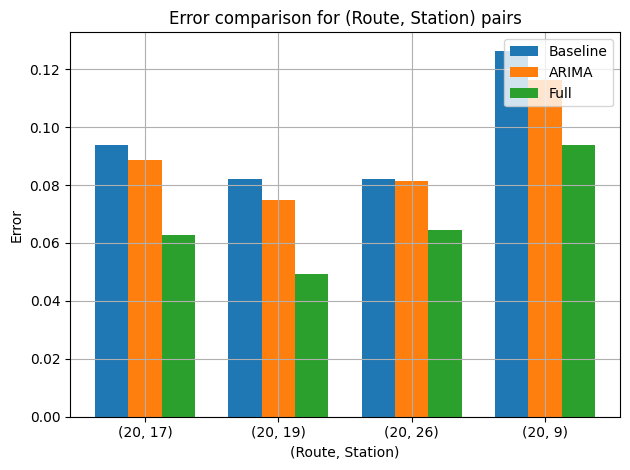

In [255]:
test.error_function(use_mean=False, use_across_days=False)